In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import re
import pandas as pd
from sklearn.linear_model import LinearRegression
from kneed import DataGenerator, KneeLocator
%run gitt.py

In [3]:
## parameters
useable_cap = 0.2/0.21
iapp1C = 96487*16/3600*100e-6*0.24/1.239e-4/useable_cap   # 1C current (A/m^2) for pars_CP_mod1 and mod2
Lcat = 100e-6
F = 96487
endt = 1.5590/1.5496*72000*useable_cap/3600 ## account for actual S initially vs theoretical S
toDOD = 1/(endt*3600)*100   # convert capacity to DOD
print(endt*3600)
Nx = 5

68987.38845047569


### Figure 1a

note (checked convergence. Nx=5 and Nx=7 matches); use Nx=5 from now on

data folder forconvergence: data-20211111-full-LT1

RMSE = 11.470834337214342 mV
with useable capacity 0.9523809523809524
we set iapp,eff = iapp,theoretical/utilization ratio to account for sulfur utilization


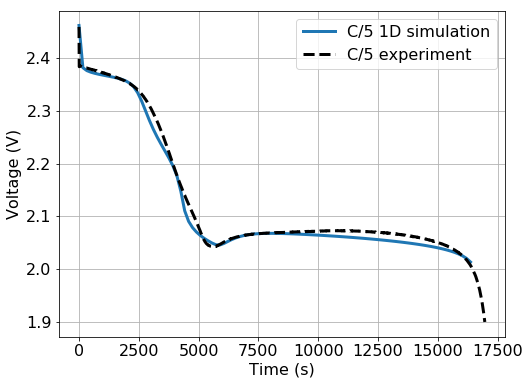

In [4]:
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})

### READ AND PLOT SIM DATA ###
folder_path = "../data/data-20211111-full-LT2-crate/"
Nrun, Nx = 4,5
fullmodel = np.loadtxt(folder_path + "avg_data_run_{}-Nx={}.txt".format(Nrun, Nx))
plt.plot(fullmodel[:,0], fullmodel[:,22], label="C/5 1D simulation", linewidth=3)


### PLOT EXPERIMENTAL DATA ###
exp_data = "../data/CP_OXIS_LT_clean/dis_Co5.csv"
df1 = pd.read_csv(exp_data)
to_cap = -df1["Current(A)"].iloc[1]/3600
plt.plot(df1["Time(s)"], df1["Voltage(V)"], 'k--',\
         label="C/5 experiment", linewidth=3)

### PLOT SETTINGS ###
plt.legend()
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")
plt.grid()

### QUANTIFY RMSE ###
vinterp = np.interp(fullmodel[:,0],df1["Time(s)"],df1["Voltage(V)"])
rmse = np.sqrt(np.square(np.subtract(vinterp, fullmodel[:,22])).mean())
print("RMSE =",rmse*1000, "mV")
print("with useable capacity {}".format(useable_cap))
print("we set iapp,eff = iapp,theoretical/utilization ratio to account for sulfur utilization")

### FIGURE 1b

1D cathode+sep full model


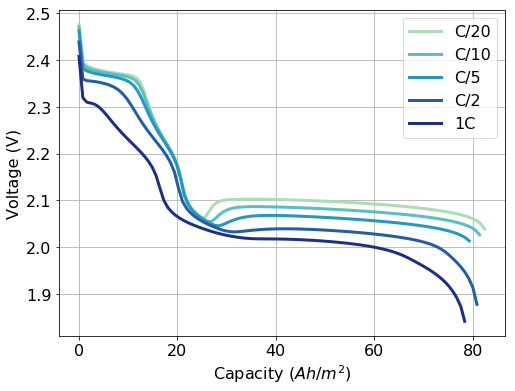

In [5]:
### READ AND SET UP DATA ###
Nx = 5
folder_path = "../data/data-20211111-full-LT2-crate/"

Nrun_arr = np.flip([2,3,4,5,6]) 
crate_arr_str = np.flip(["1C", "C/2", "C/5","C/10", "C/20"])
crate_arr = np.flip([1,0.5,0.2, 0.1,0.05])

### PLOT SETTINGS ###
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
cmap = plt.cm.YlGnBu(np.linspace(0.3,0.9,len(Nrun_arr)))
lines1d = []

### PLOT SIMULATIONS ###
for (Nrun,crate,crate_str,clr) in zip(Nrun_arr,crate_arr,crate_arr_str,cmap):
    data = np.loadtxt(folder_path + 
                      "avg_data_run_{}-Nx={}.txt".format(Nrun,Nx))
    lines1d += plt.plot(data[:,0]/3600*crate*iapp1C, data[:,22], 
             linewidth=3, color=clr, label=crate_str)
    


### PLOT SETTINGS ###
labels1d = [l.get_label() for l in lines1d]
leg1 = plt.legend(lines1d, labels1d, loc="upper right")
plt.ylabel("Voltage (V)")
plt.xlabel("Capacity $(Ah/m^2)$")
plt.grid()
print("1D cathode+sep full model")

### FIGURE 2

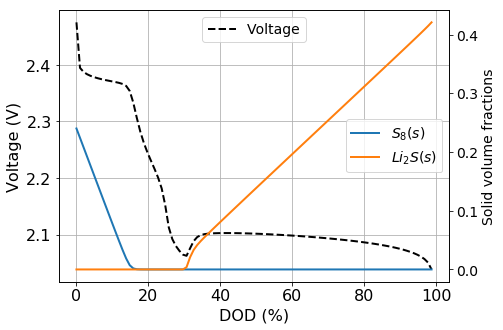

In [7]:
### READ DATA ###
crate, Nrun = 0.05, 6
folder_path = "../data/data-20211111-full-LT2-crate/"
Co20data = np.loadtxt(folder_path + 
                      "avg_data_run_{}-Nx={}.txt".format(Nrun, Nx))
data = Co20data

### PLOT ###
volfrac_lbl = ["$S_8(s)$", "$Li_2S(s)$"]
fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

# plot voltage
ax1.plot(data[:,0]*toDOD,data[:,22], 'k--',label="Voltage", linewidth=2)
ax2 = ax1.twinx()

# plot vol fracs
for j,i in enumerate(range(15,17)):
    ax2.plot(data[:,0]*toDOD,data[:,i], label=volfrac_lbl[j], linewidth=2)

ax1.set_xlabel("DOD (%)")
ax2.set_ylabel("Solid volume fractions", color='k')
ax1.set_ylabel('Voltage (V)', color='k')
ax1.legend(loc="upper center")
ax2.legend(loc="center right")
ax1.grid()

### FIGURE 3a

49


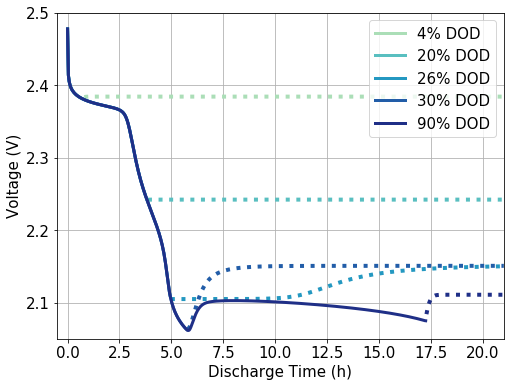

In [8]:
### READ DATA ###
folder_path = "../data/data-20211111-full-LT2-relax/"
run_arr, Nrun_arr, dod_arr, crate_arr = readFullRelaxFiles(folder_path)

### PLOT ###
dod_to_plot = [4,20,26,30,90]

plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 15})
cmap = plt.cm.YlGnBu(np.linspace(0.3,0.9,len(dod_to_plot)))
for (dod,clr) in zip(dod_to_plot,cmap):
    file_ind = np.isclose(dod_arr,dod).nonzero()[0][0]
    data = np.loadtxt(folder_path + run_arr[file_ind])
    full1 = GittDataFull1D_catsep(data, dod, crate, endt, Nx)
    full1.split_relax()
    
    plt.plot(full1.timeOn, full1.voltageOn,'-',linewidth=3, color=clr, label=str(int(dod))+"% DOD")
    plt.plot(full1.timeOff, full1.voltageOff,':',linewidth=4, color=clr)
    
    
plt.xlabel("Discharge Time (h)")
plt.ylabel("Voltage (V)")
plt.ylim(2.05,2.5)
plt.xlim(-0.5,21)
plt.grid()
plt.legend(loc="upper right")

### FIGURE 3b

In [9]:
### READ DATA ###
folder_path = "../data/data-20211111-full-LT2-relax/"
run_arr, Nrun_arr, dod_arr, crate_arr = readFullRelaxFiles(folder_path)

### GET RELAXED VOLTAGES FROM TIME DOMAIN FULL MODEL RELAXATION SIMS ###
relaxV = []
for (file_name) in (run_arr):
    data = np.loadtxt(folder_path + file_name)
    ndepvars, neps = 23, 6
    voltage =  data[:,ndepvars*Nx + (ndepvars-neps)*2 -1]
    relaxV.append(voltage[-1])

49


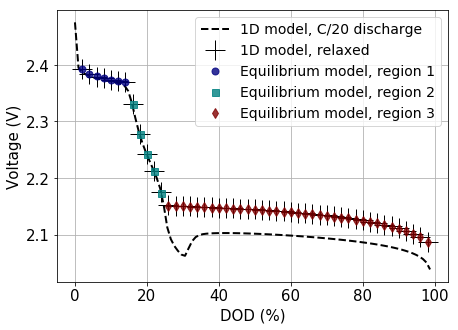

In [10]:
fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

# PLOT DISCHARGE
ax1.plot(Co20data[:,0]*toDOD,Co20data[:,22], 'k--',label="1D model, C/20 discharge", linewidth=2)

# PLOT FULL MODEL RELAXED VOLTAGE
ax1.plot(dod_arr, relaxV, '+', color="k", alpha=1, markersize=20, label="1D model, relaxed")


# EQUILIBRIUM THERMO DATA
df_thermo = pd.read_csv("../data/data-20211111-thermo/thermo_withsep_LT2.csv")
# defining the 3 regions by lower and upper bounds of region 2, inclusive
dod_r2LB = 15 
dod_r2UB = 24
r1 = np.arange(2,dod_r2LB,2)
r2 = np.arange(dod_r2LB+1,dod_r2UB+1,2)
r3 = np.arange(dod_r2UB+2,100,2)

# PLOT THERMO
ax1.plot(r1,df_thermo["x8"].loc[r1-1], 'o', color="navy", alpha=0.8, markersize=7, label='Equilibrium model, region 1')
ax1.plot(r2,df_thermo["x8"].loc[r2-1], 's', color="teal", alpha=0.8, markersize=7, label='Equilibrium model, region 2')
ax1.plot(r3,df_thermo["x8"].loc[r3-1], 'd', color="maroon", alpha=0.8, markersize=7, label='Equilibrium model, region 3')


ax1.set_xlabel("DOD (%)")
ax1.set_ylabel('Voltage (V)', color='k')
ax1.legend(loc="upper right")
ax1.grid()
# ax1.set_ylim(2.05,2.5)

### FIGURE 4a

Text(0.5, 0, 'Time (s)')

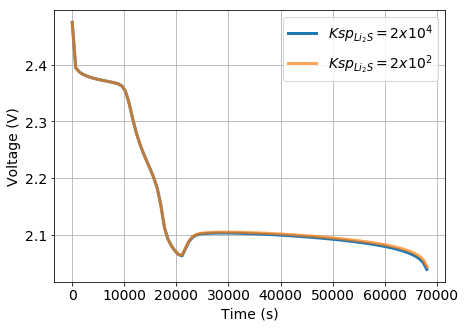

In [11]:
fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

# PLOT BASE CASE DISCHARGE
plt.plot(Co20data[:,0],Co20data[:,22], label="$Ksp_{Li_2S}=2x10^4$", linewidth=3)

### READ AND PLOT SIM DATA ###
folder_path = "../data/data-20211112-full-LT2-Ksp/"
Nrun, Nx = 1,5
fullmodel = np.loadtxt(folder_path + "avg_data_run_{}-Nx={}.txt".format(Nrun, Nx))
plt.plot(fullmodel[:,0], fullmodel[:,22], label="$Ksp_{Li_2S}=2x10^2$", linewidth=3, alpha=0.7)

plt.legend()
plt.grid()
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")

### FIGURE 4b

(2.05, 2.45)

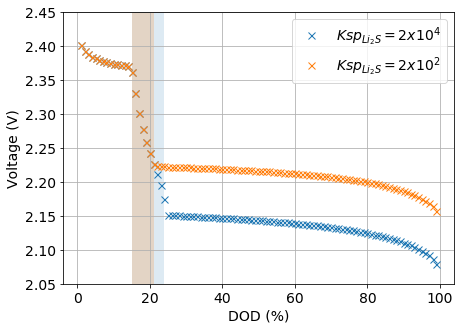

In [211]:
# EQUILIBRIUM THERMO DATA - VARIOUS KSP-Li2S
df_thermo0 = pd.read_csv("../data/data-20211111-thermo/thermo_withsep_LT2.csv")
df_thermo1 = pd.read_csv("../data/data-20211111-thermo/thermo_withsep_LT2_Kspx0.01.csv")

fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

dodRange = np.arange(1,100)
plt.plot(dodRange,df_thermo0["x8"].loc[dodRange-1], 'x', markersize=7, label="$Ksp_{Li_2S}=2x10^4$")
plt.plot(dodRange,df_thermo1["x8"].loc[dodRange-1], 'x', markersize=7, label="$Ksp_{Li_2S}=2x10^2$")

plt.fill_between(np.arange(15,25),2.05,2.45,alpha=0.15)  # thermo0 region 2: 15-24% dod
plt.fill_between(np.arange(15,22),2.05,2.45,alpha=0.2)  # thermo1 region 2: 15-21% dod

plt.legend()
plt.grid()
plt.ylabel("Voltage (V)")
plt.xlabel("DOD (%)")
plt.ylim(2.05,2.45)

### FIGURE 4c

Text(0.5, 0, '$Ksp_{Li_2S}$ $\\left(\\frac{mol^3}{m^9}\\right)$')

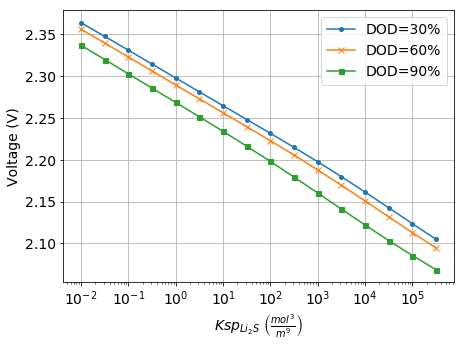

In [144]:
# EQUILIBRIUM THERMO DATA - TIE LINES
df_Ksp = pd.read_csv("../data/data-20211111-thermo/KspLi2S_phi_mat.csv")
df_Ksp.columns = ["KspLi2S","DOD=30%", "DOD=60%","DOD=90%"]

fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

plt.semilogx(df_Ksp["KspLi2S"], df_Ksp["DOD=30%"], "o-", markersize = 4, label="DOD=30%")
plt.semilogx(df_Ksp["KspLi2S"], df_Ksp["DOD=60%"], "x-", markersize = 6, label="DOD=60%")
plt.semilogx(df_Ksp["KspLi2S"], df_Ksp["DOD=90%"], "s-", markersize = 5, label="DOD=90%")

plt.legend()
plt.grid()
plt.ylabel("Voltage (V)")
plt.xlabel("$Ksp_{Li_2S}$ "+ "$\\left(\\frac{mol^3}{m^9}\\right)$")

### FIGURE 4d

Text(0.5, 0, '$Ksp_{Li_2S}$ $\\left(\\frac{mol^3}{m^9}\\right)$')

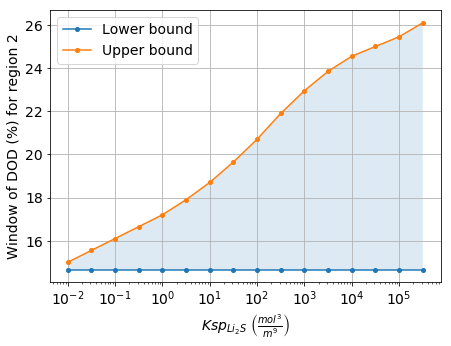

In [229]:
# EQUILIBRIUM THERMO DATA - FOR BOUNDS OF REGION 2
df_Ksp_r2b = pd.read_csv("../data/data-20211111-thermo/KspLi2S_r2bounds_mat.csv")
df_Ksp_r2b.columns = ["KspLi2S","R2_LB", "R2_UB"]

fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

plt.semilogx(df_Ksp_r2b["KspLi2S"], df_Ksp_r2b["R2_LB"], "o-", markersize = 4, label="Lower bound")
plt.semilogx(df_Ksp_r2b["KspLi2S"], df_Ksp_r2b["R2_UB"], "o-", markersize = 4, label="Upper bound")

plt.fill_between(df_Ksp_r2b["KspLi2S"],df_Ksp_r2b["R2_LB"],df_Ksp_r2b["R2_UB"],alpha=0.15)  


plt.legend()
plt.grid()
plt.ylabel("Window of DOD (%) for region 2")
plt.xlabel("$Ksp_{Li_2S}$ "+ "$\\left(\\frac{mol^3}{m^9}\\right)$")

### FIGURE 5a

kf=1e-5
RMSE = 5.915678240561667 mV


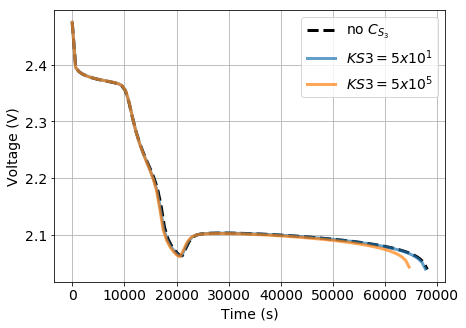

In [17]:
fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

### READ AND PLOT SIM DATA ###
plt.plot(Co20data[:,0],Co20data[:,22], 'k--', label="no $C_{S_3}$", linewidth=3, )

folder_path = "../data/data-20211112-full-LT2-S3/"
Nrun, Nx = 2,5
fullmodel = np.loadtxt(folder_path + "avg_data_run_{}-Nx={}.txt".format(Nrun, Nx))
plt.plot(fullmodel[:,0], fullmodel[:,24], label="$KS3=5x10^1$", linewidth=3, alpha=0.7)

Nrun, Nx = 1,5
fullmodel = np.loadtxt(folder_path + "avg_data_run_{}-Nx={}.txt".format(Nrun, Nx))
plt.plot(fullmodel[:,0], fullmodel[:,24], label="$KS3=5x10^5$", linewidth=3, alpha=0.7)

plt.legend()
plt.grid()
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")

print("kf=1e-5")

vinterp = np.interp(Co20data[:,0],fullmodel[:,0], fullmodel[:,24])
rmse = np.sqrt(np.square(np.subtract(vinterp, Co20data[:,22])).mean())
print("RMSE =",rmse*1000, "mV")

### FIGURE 5b

(2.05, 2.5)

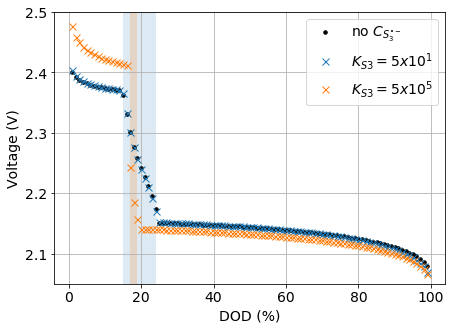

In [213]:
# EQUILIBRIUM THERMO DATA - VARIOUS KSP-Li2S
df_thermo0 = pd.read_csv("../data/data-20211111-thermo/thermo_withsep_LT2.csv")
df_thermoS3_1 = pd.read_csv("../data/data-20211111-thermo/thermo_withsep_LT2_KS3=5e1.csv")
df_thermoS3_2 = pd.read_csv("../data/data-20211111-thermo/thermo_withsep_LT2_KS3=5e5.csv")


fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

dodRange = np.arange(1,100)
plt.plot(dodRange,df_thermo0["x8"].loc[dodRange-1], 'k.', markersize=7, label="no $C_{S_3^{•-}}$")
plt.plot(dodRange,df_thermoS3_1["x8"].loc[dodRange-1], 'x', markersize=7, label="$K_{S3}=5x10^1$")
plt.plot(dodRange,df_thermoS3_2["x8"].loc[dodRange-1], 'x', markersize=7, label="$K_{S3}=5x10^5$")

plt.fill_between(np.arange(15,25),2.05,2.5,alpha=0.15)  # thermo1 region 2: 15-24% dod
plt.fill_between(np.arange(17,20),2.05,2.5,alpha=0.2)  # thermo2 region 2: 17-19% dod


plt.legend()
plt.grid()
plt.ylabel("Voltage (V)")
plt.xlabel("DOD (%)")
plt.ylim(2.05,2.5)

### FIGURE 5c

Text(0.5, 0, '$K_{S3}$ $\\left(\\frac{mol}{m^3}\\right)$')

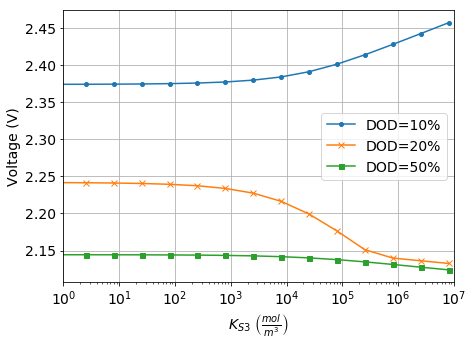

In [30]:
# EQUILIBRIUM THERMO DATA - TIE LINES
df_KS3 = pd.read_csv("../data/data-20211111-thermo/KS3_phi_mat.csv")
df_KS3.columns = ["KS3","DOD=10%", "DOD=20%","DOD=50%"]

fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

plt.semilogx(df_KS3["KS3"], df_KS3["DOD=10%"], "o-", markersize = 4, label="DOD=10%")
plt.semilogx(df_KS3["KS3"], df_KS3["DOD=20%"], "x-", markersize = 6, label="DOD=20%")
plt.semilogx(df_KS3["KS3"], df_KS3["DOD=50%"], "s-", markersize = 5, label="DOD=50%")

plt.legend()
plt.grid()
plt.xlim(1,1e7)
plt.ylabel("Voltage (V)")
plt.xlabel("$K_{S3}$ "+ "$\\left(\\frac{mol}{m^3}\\right)$")

### FIGURE 5d

Text(0.5, 0, '$K_{S3}$ $\\left(\\frac{mol}{m^3}\\right)$')

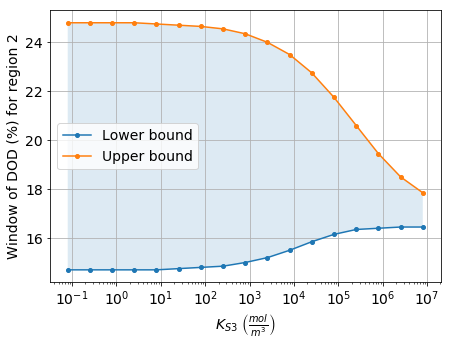

In [230]:
# EQUILIBRIUM THERMO DATA - FOR BOUNDS OF REGION 2
df_KS3_r2b = pd.read_csv("../data/data-20211111-thermo/KS3_r2bounds_mat.csv")
df_KS3_r2b.columns = ["KspLi2S","R2_LB", "R2_UB"]

fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})

plt.semilogx(df_KS3_r2b["KspLi2S"], df_KS3_r2b["R2_LB"], "o-", markersize = 4, label="Lower bound")
plt.semilogx(df_KS3_r2b["KspLi2S"], df_KS3_r2b["R2_UB"], "o-", markersize = 4, label="Upper bound")

plt.fill_between(df_KS3_r2b["KspLi2S"],df_KS3_r2b["R2_LB"],df_KS3_r2b["R2_UB"],alpha=0.15)  

plt.legend()
plt.grid()
plt.ylabel("Window of DOD (%) for region 2")
plt.xlabel("$K_{S3}$ "+ "$\\left(\\frac{mol}{m^3}\\right)$")

### FIGURE 6a

Characteristic time =  8.45


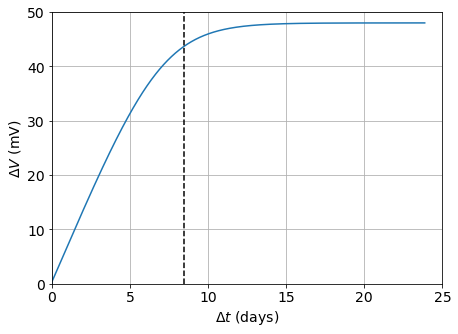

In [214]:
# READ FUll 1D DATA with S3
folder_path = "../data/data-20211112-full-LT2-S3-relax/"
Nrun, Nx, dod = 1, 5, 10
data = np.loadtxt(folder_path + "avg_data_run_{}-Nx={}.txt".format(Nrun,Nx))

# SPLIT UP RELAXATION DATA -- START FROM ZERO
full1 = GittDataFull1D_catsep_AvgVars(data, dod, crate, endt, Nx)
full1.split_relax(zeroMode=True)

# KNEE LOCATOR
y = full1.voltageOff*1000
x = full1.timeOff/24
kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")

# PLOT
fig, ax1 = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})
plt.plot(full1.timeOff/24, full1.voltageOff*1000)
plt.plot(np.ones(10)*round(kneedle.knee, 3), np.linspace(0,50,10), 'k--')
plt.xlabel("$\Delta t$ (days)")
plt.ylabel("$\Delta V$ (mV)")
plt.grid()
plt.xlim(0,25)
plt.ylim(0,50)

print("Characteristic time = ", round(kneedle.knee, 3))

In [216]:
kfS3_arr = [1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2, 2e-2] #1e0,1e1,1e2,1e3]
Nrun_arr = [1,7,6,2,8,18,3,9,16,5,10] #12,13,14,15, 4]

kfS3_knee_mat = np.zeros(len(kfS3_arr))  ## knee point 
kfS3_deltaV_mat = np.zeros(len(kfS3_arr)) ## magnitude of relaxed voltage

for i,(kfS3,Nrun) in enumerate(zip(kfS3_arr,Nrun_arr)):
    # READ FUll 1D DATA with S3
    folder_path = "../data/data-20211118-full-LT2-S3-relax-kf/"
    Nx, dod = 5, 10
    data = np.loadtxt(folder_path + "avg_data_run_{}-Nx={}.txt".format(Nrun,Nx))

    # SPLIT UP RELAXATION DATA -- START FROM ZERO
    full1 = GittDataFull1D_catsep_AvgVars(data, dod, crate, endt, Nx)
    full1.split_relax(zeroMode=True)

    # KNEE LOCATOR
    y = full1.voltageOff*1000
    x = full1.timeOff/24
    kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")
    
    # STORE LOCATION OF KNEE
    print("Characteristic time = ", round(kneedle.knee, 3))
    kfS3_knee_mat[i] = kneedle.knee
    
    # STORE RELAXED VOLTAGE MAGNITUDE
    kfS3_deltaV_mat[i] = full1.voltageOff[-1]
    

Characteristic time =  8.45
Characteristic time =  5.024
Characteristic time =  2.362
Characteristic time =  1.297
Characteristic time =  0.719
Characteristic time =  0.302
Characteristic time =  0.156
Characteristic time =  0.081
Characteristic time =  0.035
Characteristic time =  0.021
Characteristic time =  0.019


### Figure 6b

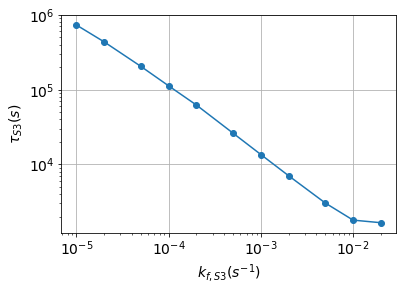

In [222]:
plt.loglog((kfS3_arr),(kfS3_knee_mat*24*3600), 'o-')
plt.ylabel("$\\tau_{S3} (s)$")
plt.xlabel("$k_{f,S3} (s^{-1}) $")
plt.grid()

### Figure 6c

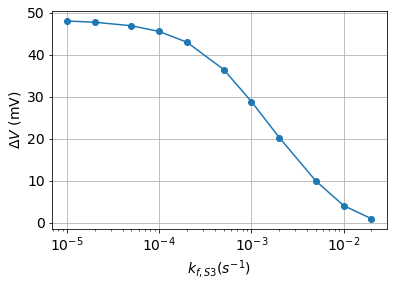

In [221]:
plt.semilogx((kfS3_arr),(kfS3_deltaV_mat*1000), 'o-')
plt.ylabel("$\Delta V$ (mV)")
plt.xlabel("$k_{f,S3} (s^{-1}) $")
plt.grid()

### FIGURE 7

In [231]:
kfS3_arr=[1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]
KS3_arr=[1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
kk_deltaV_mat = np.zeros((len(kfS3_arr)*len(KS3_arr),3)) ## magnitude of relaxed voltage

count=0
for kfS3 in kfS3_arr:
    for KS3 in KS3_arr:
        count+=1

        # READ FUll 1D DATA with S3
        folder_path = folder_path = "../data/data-20211203-full-LT2-S3-relax-KS3-kf/"
        Nrun, Nx, dod = count, 5, 10
        data = np.loadtxt(folder_path + "avg_data_run_{}-Nx={}.txt".format(Nrun,Nx))

        # SPLIT UP RELAXATION DATA -- START FROM ZERO
        full1 = GittDataFull1D_catsep_AvgVars(data, dod, crate, endt, Nx)
        full1.split_relax(zeroMode=True)

        # STORE RELAXED VOLTAGE MAGNITUDE
        kk_deltaV_mat[count-1] = full1.voltageOff[-1], kfS3, KS3                        

Text(0.5, 0, '\n $log \\left[ k_{f,S3} (s^{-1})  \\right]$')

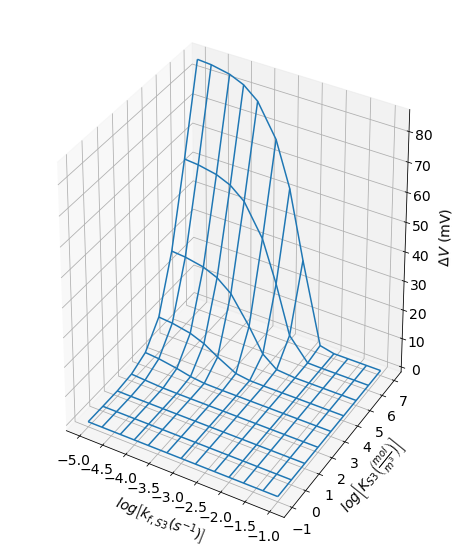

In [232]:
# EQUILIBRIUM THERMO DATA - TIE LINES
x, y = np.log10(kk_deltaV_mat[:,1]).reshape(13,9), np.log10(kk_deltaV_mat[:,2]).reshape(13,9)  #kfS3 x KS3
z = kk_deltaV_mat[:,0].reshape(13,9)*1000

from mpl_toolkits.mplot3d import axes3d
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x,y,z)

# plt.legend()
plt.grid()
# plt.xlim(1,1e7)
ax.set_zlabel("\n $\Delta V$ (mV)")
ax.set_ylabel("\n $log \\left[ K_{S3} \\left(\\frac{mol}{m^3}\\right) \\right]$")
ax.set_xlabel("\n $log \\left[ k_{f,S3} (s^{-1})  \\right]$")